# Turning distance sensor into useful map info

The distance sensor has a cone like beam. When it returns a hit it gives information about:
1. The distance of the objects
2. The emptiness of the space between

This is a jupyter notebook to help me understand what the probablilty finction looks like.

In [16]:
from math import exp,sqrt,atan, tan,cos,sin
from pint import UnitRegistry
import numpy as np
ureg = UnitRegistry()

In [17]:
class observation:
    def __init__(self,distance,angle):
        self.distance =distance
        self.angle = angle
    def OPP(self,x,theta):
        cone = exp((-1/sqrt(2))*((theta)/(10*ureg.degrees))**2)
        incidence = 0.8*exp((-1/sqrt(2))*((self.distance-x).to('cm').magnitude/(2.5))**2) - 0.4
        opp=0.5 + cone*incidence
        if x>self.distance and opp<0.5:
            return(0.5)
        else:
            return opp

    
    

In [18]:
ob = observation(35*ureg.cm,0*ureg.degrees)

In [19]:
ob.OPP(35*ureg.cm,0*ureg.degrees)

0.9

<IPython.core.display.Javascript object>


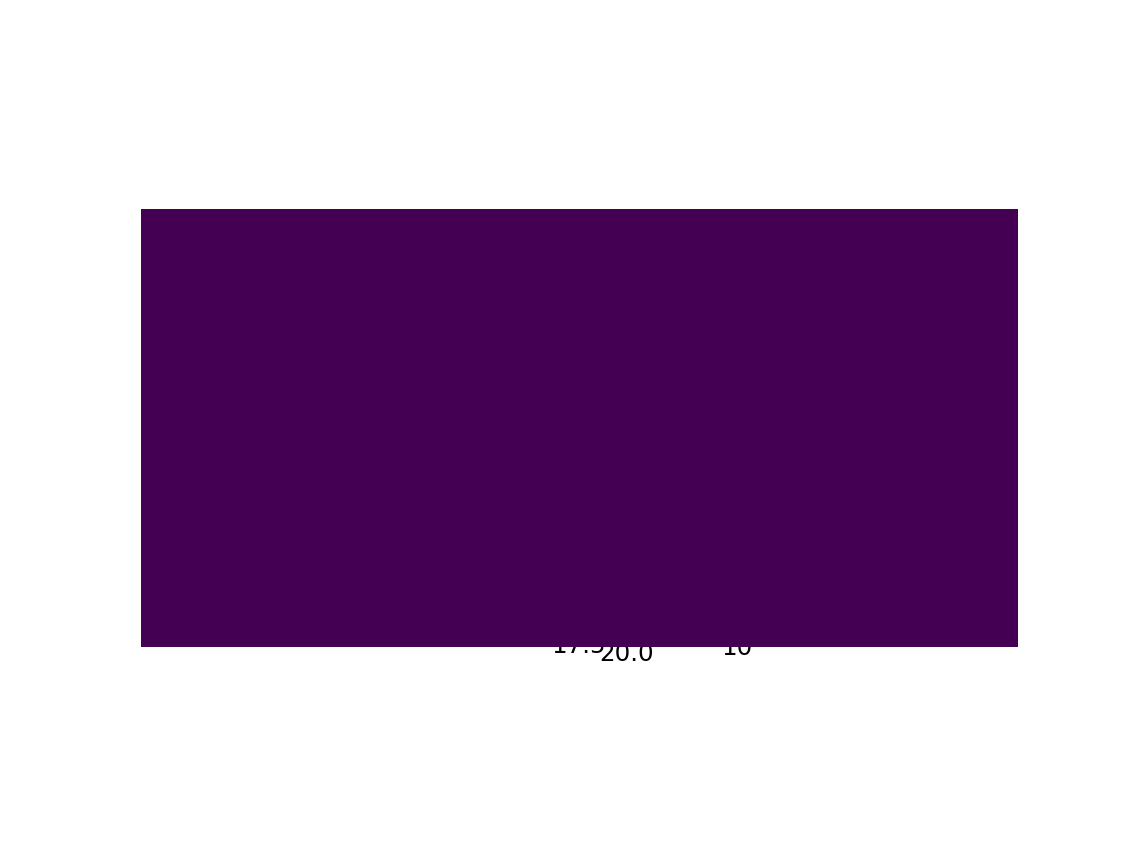

In [20]:
import matplotlib.pyplot as plt

from mpl_toolkits.mplot3d import axes3d
%matplotlib notebook
N = 50
hw = int(N/2)
X, Y = np.meshgrid(range(N), range(N))  # `plot_surface` expects `x` and `y` data to be 2D

PDF = np.ones((N,N))*0.5

for x in range(1,N):
    for y in range(-hw,hw):
        theta = atan(y/x)*ureg.radians
        PDF[x,y+hw]=ob.OPP(x*ureg.cm,theta)
        
hf = plt.figure()
ha = hf.add_subplot(111, projection='3d')
ha.plot_surface(X, Y, PDF, facecolors=plt.cm.jet(PDF))

I need to find a smart way of turning this into a usable list

In [44]:
class observation:
    def __init__(self,distance,angle, position = np.array([0,0])*ureg.cm):
        self.distance =distance
        self.angle = angle.to('radians')
        self.position = position
    def OPP(self,x,theta):
        cone = np.exp((-1/sqrt(2))*((theta)/(10*ureg.degrees))**2)
        if self.distance>45*ureg.cm:
            incidence=0.1*np.ones(x.shape)
        else:
            incidence = 0.8*np.exp((-1/sqrt(2))*((self.distance-x).to('cm').magnitude/(2.5))**2) - 0.4
        opp=0.5 + cone*incidence
        m1 = (x>self.distance)*(opp<0.5)
        opp[m1]=0.5
        
        return opp
    
    def global_OPP(self, coarse=5*ureg.cm):
        rect = int((round(self.distance + 2*2.5*ureg.cm)/coarse + 1).magnitude)
        width = int((tan((10*ureg.degrees).to('radians'))*rect))+1
        X, Y = np.meshgrid(range(1,rect), range(-width,width+1))*coarse
        theta = np.arctan(Y/X)*ureg.radians
        mip = self.OPP(X,theta)
        return mip
        
    def global_OPP_ptcl(self,coarse=5*ureg.cm):
        mip = self.global_OPP(coarse=5*ureg.cm)
        MASK = (mip<0.45) +  (mip>0.55)
        vals = mip[MASK]
        coords = np.argwhere(MASK)
        c = cos(self.angle)
        s = sin(self.angle)
        R = np.array([[c,-s],[s,c]])
        coords =np.dot(coords,R.T)
        coords[:,0] += self.position[0]/coarse
        coords[:,1] += self.position[1]/coarse
        return (np.round(coords).astype(int),vals)
        

In [45]:
ob = observation(50*ureg.cm,45*ureg.degrees, position=np.array([100,700])*ureg.cm)

In [46]:
a=ob.global_OPP(coarse = 2.5*ureg.cm)

In [47]:
plt.imshow(a)

In [48]:
pv=ob.global_OPP_ptcl()

In [49]:
class mapper:
    
    def __init__(self,size, pixel_width=5*ureg.cm):
        self.map = np.ones(size)*0.5
        self.coarse = pixel_width
    def update(self,observation):
        pv = observation.global_OPP_ptcl(coarse=self.coarse)
        X = pv[0][:,0]
        Y = pv[0][:,1]
        old=self.map[X,Y]
        self.map[X,Y] = (pv[1]*old)/(pv[1]*old +(1-pv[1])*(1-old))



In [50]:
my_map = mapper((200,200))

from random import uniform
for i in range(50,700,2):
    my_map.update(observation((50+uniform(-1,1)*10)*ureg.cm,(90 +uniform(-1,1))*ureg.degrees, position=np.array([100,i])*ureg.cm))

<IPython.core.display.Javascript object>


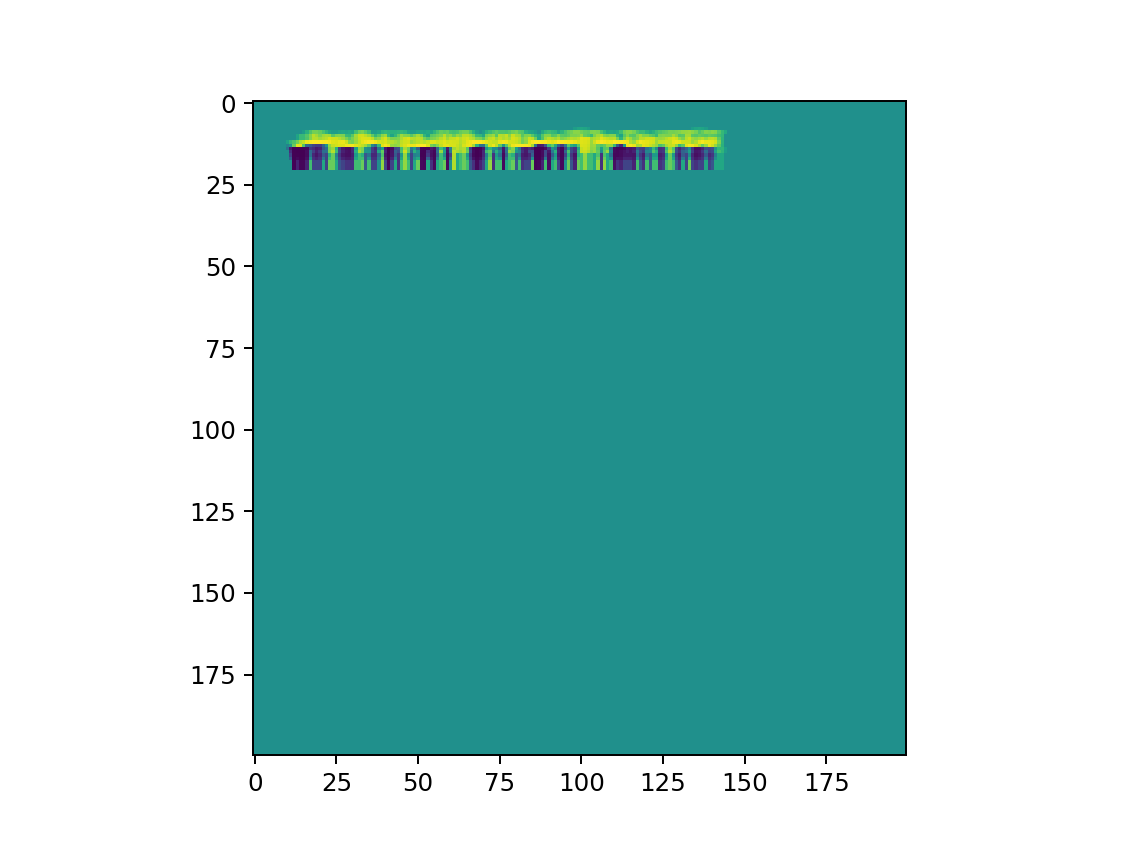

In [51]:
plt.figure()
plt.imshow(my_map.map)